# Extract Sentences from Wikipedia
+ This notebook is used for collecting sentences that tell relationship between two entities from wikipedia using some dependency path pattern
+ **This notebook is fully valid under Owl3 machine (using the /scratch/data/wikipedia/full_text-2021-03-20 data)**

## Load necessary resource

In [1]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import sys
import wikipedia
import os
from wikipedia2vec import Wikipedia2Vec
import wikipedia2vec
from collections import Counter
import bz2
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
from typing import List
from nltk.corpus import stopwords
self_define_stopwords = set(['-', ',', '.'])
sw = set(stopwords.words('english'))
import math
import json
import random
random.seed(0)
import torch

sys.path.append('..')

from tools.BasicUtils import my_read, my_write, my_read_pickle, my_write_pickle
from tools.TextProcessing import (
                my_sentence_tokenize,
                my_sentence_tokenize, filter_specific_keywords, nlp, 
                exact_match, find_span
                )

from extract_wiki import (
    save_path, entity_occur_from_cooccur_file, graph_file, single_sent_graph_file, 
    w2vec_dump_file, sub_path_pattern_count_file, 
    w2vec_keyword2idx_file, 
    test_path, path_test_file, 
    path_pattern_count_file, 
    save_sub_folders, wiki_sub_folders, 
    wiki_files, save_sent_files, save_cooccur_files, save_selected_files, 
    p, patterns, FeatureProcess, 
    note2line, cal_score_from_df, cal_freq_from_path, cal_freq_from_df, 
    gen_pattern, gen_kw_from_wiki_ent, get_entity_page, load_pattern_freq, find_triangles, find_path_between_pair, 
    generate_sample, generate_second_level_sample, sample_to_neo4j, get_sentence, informativeness_demo, find_dependency_info_from_tree, process_list
)

# Generate the save dir
if not os.path.exists(save_path):
    os.mkdir(save_path)

if not os.path.exists(test_path):
    os.mkdir(test_path)

for save_dir in save_sub_folders:
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

# Get all files under wikipedia/full_text-2021-03-20

print('wiki sub folder example:', wiki_sub_folders[0])
print('save sub folder example:', save_sub_folders[0])
print('wiki file example:', wiki_files[0])
print('save sentence file example:', save_sent_files[0])
print('save cooccur file example:', save_cooccur_files[0])
print('save selected sentence file example:', save_selected_files[0])

wiki sub folder example: ../data/wikipedia/full_text-2021-03-20/BE
save sub folder example: data/extract_wiki/wiki_sent_collect/BE
wiki file example: ../data/wikipedia/full_text-2021-03-20/BE/wiki_00
save sentence file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00.dat
save cooccur file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00_co.dat
save selected sentence file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00_se.dat


In [ ]:
# [Load] wikipedia2vec
with bz2.open(w2vec_dump_file) as f_in:
    w2vec = Wikipedia2Vec.load(f_in)

In [ ]:
# [Test] wikipedia2vec

# Find similar words or entities
# ent1 = 'Python (programming language)'
# w2vec.most_similar_by_vector(w2vec.get_entity_vector(ent1), 20)

# Get similarity between two entities
ent1 = 'Machine learning'
ent2 = 'Information science'
cosine_similarity(w2vec.get_entity_vector(ent1).reshape(1, -1), w2vec.get_entity_vector(ent2).reshape(1, -1))[0, 0]

# Check the entity count and document count
# ent1 = 'Hidden Markov model'
# e = w2vec.get_entity(ent1)
# print(e.count)
# print(e.doc_count)

## [Preparation] Collect sentences, entities, entities co-occurrances, titles from wikipedia dump

### Roughly collect sentences, entity co-occurrances, titles

In [ ]:
# [Test] Test get_sentence function
get_sentence('ir_2.txt', 'sent.txt', 'cooccur.txt', 'title.txt')

In [ ]:
# python extract_wiki.py collect_sent_and_cooccur (8 hours)

### Correct entity mapping in co-occurrance files

In [ ]:
# python extract_wiki.py correct_mapping_in_cooccur (6 mins)

In [ ]:
doc = nlp("Late in the year, ""Oz"" published a feature called ""The Oz Guide to Sydney's Underworld"", which was based on information from two local journalists, and which included a ""top 20"" list of Sydney major criminals.")

In [ ]:
len(doc)

In [ ]:
# [Test]
lines = get_entity_page('Oz (magazine)')
# sents = [note2line(note) for note in lines]
# occurs = [note2line(note, '_co_.dat') for note in lines]
# ori_occurs = [note2line(note, '_co.dat') for note in lines]
# my_write('sent_check.txt', sents)
# my_write('occur_check.txt', occurs)
# my_write('ori_occur_check.txt', ori_occurs)
lines[0]

### Generate entity occurrance from dataset

In [ ]:
# Generate the entity occurrance dict from co-occurrance info [collect_ent_occur_from_cooccur]

### [Not necessary] Mapping keyword mention to wikipedia2vec entities

In [ ]:
wikipedia_entity
w2vec

w2vec_keyword2idx = {}

for entity in tqdm.tqdm(wikipedia_entity):
    w2vec_entity = w2vec.get_entity(entity)
    if w2vec_entity is None:
        continue
    kw = gen_kw_from_wiki_ent(entity)
    if kw not in w2vec_keyword2idx:
        w2vec_keyword2idx[kw] = [w2vec_entity.index]
    else:
        if w2vec_entity.index not in w2vec_keyword2idx[kw]:
            w2vec_keyword2idx[kw].append(w2vec_entity.index)
w2vec_kws = filter_specific_keywords(list(w2vec_keyword2idx.keys()))
filter_keyword_from_w2vec = set(w2vec_kws)
w2vec_keyword2idx = {k:v for k, v in w2vec_keyword2idx.items() if k in filter_keyword_from_w2vec}
my_write_pickle(w2vec_keyword2idx_file, w2vec_keyword2idx)
len(w2vec_keyword2idx)

In [ ]:
# [Load] w2vec_keyword2idx
w2vec_keyword2idx = my_read_pickle(w2vec_keyword2idx_file)

In [ ]:
# [Test] w2vec_keyword2idx
kw = 'feature engineering'
kw_in_mention = kw in w2vec_keyword2idx
print(kw_in_mention)
if kw_in_mention:
    for idx in w2vec_keyword2idx[kw]:
        print(w2vec.dictionary.get_item_by_index(idx))

## [Preparation] Collect dataset

### Collect pattern frequency counter

In [ ]:
# [Create] [collect_pattern_freq] (12 min)

In [ ]:
# [Load] cal_freq function
c, log_max_cnt = load_pattern_freq(path_pattern_count_file)
c.most_common(10)

In [ ]:
# [Test] cal_freq function
cal_freq_from_path('i_nsubj prep pobj prep pobj prep pobj', c, log_max_cnt)

In [ ]:
test_df = pd.read_csv(path_test_file, sep='\t')

In [ ]:
test_df.head()

In [ ]:



# path = get_path(doc, kw1_steps, kw2_steps)
# expand_dependency_info_from_tree(doc, branch)

In [ ]:
# Test find dependency path
data = test_df.iloc[2]
doc = nlp(data['sent'])
kw1_span = eval(data['kw1_span'])
kw2_span = eval(data['kw2_span'])
print(doc)
kw1_steps, kw2_steps, branch = find_dependency_info_from_tree(doc, doc[kw1_span[0] : kw1_span[1]+1], doc[kw2_span[0] : kw2_span[1]+1])
ans = get_path(doc, kw1_steps, kw2_steps)
print(data['kw1'], data['kw1_span'])
print(data['kw2'], data['kw2_span'])
print(ans)
print()
ans = collect_sub_dependency_path(doc, branch)
for item in ans:
    print(doc[item[0]], '----', item[1], '----', doc[item[2]])

In [ ]:
# Test find sub dependency path
data = test_df.iloc[1]
doc = nlp(data['sent'])
kw1_span = eval(data['kw1_span'])
kw2_span = eval(data['kw2_span'])
print(doc)
kw1_steps, kw2_steps, branch = find_dependency_info_from_tree(doc, doc[kw1_span[0] : kw1_span[1]+1], doc[kw2_span[0] : kw2_span[1]+1])
ans = collect_sub_dependency_path(doc, branch)
for item in ans:
    print(doc[item[0]], '----', item[1], '----', doc[item[2]])

In [ ]:
doc[10]

### Collect data

In [ ]:
# [Create] collect dataset [collect_dataset]

## [Prepration] Sentence-edged Graph

### Generate graph

In [ ]:
# Generate the graph ['generate_graph']

### Generate single sentence graph

In [ ]:
# Generate single sentence graph ['generate_single_sent_graph']

## [Test] Check the score function

In [11]:
# [Load] Graph
graph:nx.Graph = my_read_pickle(graph_file)

print('num of nodes:', len(graph.nodes))
print('num of edges:', len(graph.edges))

single_sent_graph:nx.Graph = my_read_pickle(single_sent_graph_file)
print('num of nodes:', len(single_sent_graph.nodes))
print('num of edges:', len(single_sent_graph.edges))

c, log_max_cnt = load_pattern_freq(path_pattern_count_file)
c.most_common(10)
d = my_read_pickle(entity_occur_from_cooccur_file)

fp = FeatureProcess(sub_path_pattern_count_file)

num of nodes: 1294502
num of edges: 2503695


In [ ]:
# [Test] graph
ent1 = 'Machine learning'
# Check the neighbours of an entity
list(graph.neighbors(ent1))

# Check the edges of two entities
# edges = graph.edges[ent1, 'Hinge loss']
# edges

### Collect highest scored sentence for pairs

In [12]:
sents = []
edges = list(single_sent_graph.edges)
random.Random(0).shuffle(edges)
for edge in edges[:100]:
    data = single_sent_graph.get_edge_data(*edge)
    sents.append({'ent1' : edge[0], 
                #   'kw1_span' : data['span'][0], 
                  'ent2' : edge[1], 
                #   'kw2_span' : data['span'][1], 
                  'sent' : note2line(data['note']).strip(), 
                  'score' : data['score']})
pd.DataFrame(sents).to_csv('highest_sents.csv', index=False)

### Single sentence significance test

In [20]:
df = informativeness_demo("Many operating systems let a program return a result when its process terminates;", 'Operating system', 'Process', fp)
df.to_csv('temp.csv', index=False)

In [24]:
fp.feature_process(nlp("Many operating systems let a program return a result when its process terminates;"), 'Operating system', 'Process')

[{'kw1_span': (1, 2),
  'kw2_span': (11, 11),
  'pattern': 'i_nsubj ccomp advcl nsubj',
  'dep_path': 'i_nsubj ccomp advcl nsubj',
  'dep_coverage': 0.8732452507251984}]

In [25]:
def cal_score(pattern_freq:float, dep_coverage:float):
    return 2 / ((1/pattern_freq)+(1/dep_coverage))
cal_score(0.8732452507251984, 0.08081373200135519)

0.14793678156435072

### Check score function on sentences from a pair of entities

In [45]:
ent1 = 'Python (programming language)'
ent2 = 'Java (programming language)'
sents = [note2line(note).strip() for note in d[ent1] & d[ent2]]
len(sents)

385

In [46]:
b = cal_freq_from_df(pd.DataFrame(process_list(sents, [str((0, ent1, ent2))]*len(sents), fp.batched_feature_process)), c, log_max_cnt)
b = cal_score_from_df(b)
b = b.sort_values(by=['score'], ascending=False)
b.to_csv('sentences.csv', index=False, columns=['kw1', 'kw1_span', 'kw2', 'kw2_span', 'sent', 'dep_coverage', 'pattern_freq', 'pattern', 'score'])

100%|██████████| 385/385 [00:05<00:00, 67.84it/s]


### Check score function on sentences from pairs containing one entity

In [29]:
examples = []
ent = 'Machine learning'
# for edge in graph.edges:
for neighbor in tqdm.tqdm(list(graph.neighbors(ent))):
    # if edge[0] not in d or edge[1] not in d:
    #     continue
    # s = d[edge[0]] & d[edge[1]]
    if neighbor not in d:
        continue
    s = d[ent] & d[neighbor]
    s = list(s)
    sents = [note2line(note).strip() for note in s]
    # pairs = [{'kw1' : gen_kw_from_wiki_ent(edge[0]), 'kw2' : gen_kw_from_wiki_ent(edge[1])}]
    pairs = [{'kw1' : gen_kw_from_wiki_ent(ent, False), 'kw2' : gen_kw_from_wiki_ent(neighbor, False)}]
    temp_list = []
    for idx, sent in enumerate(sents):
        res = fp.batched_feature_process(sent, pairs)
        for i in res:
            i['sent'] = sent
            i['note'] = s[idx]
        temp_list.extend(res)
    if not temp_list:
        continue
    df = pd.DataFrame(temp_list)
    df = cal_freq_from_df(df, c, log_max_cnt)
    df = cal_score_from_df(df)
    # if len(df) >= 5:
    #     df = df[:5]
    df = df.sort_values(by=['score'], ascending=False)
    examples.append(df)
        # if len(examples) >= 10:
        #     break

test_df = pd.concat(examples)
test_df.to_csv(ent + '.csv', index=False, columns=['kw1', 'kw1_span', 'kw2', 'kw2_span', 'note', 'sent', 'dep_coverage', 'pattern_freq', 'pattern', 'score'])
len(test_df)

100%|██████████| 232/232 [00:23<00:00,  9.96it/s]


313

In [ ]:
new_examples = []
for i in range(len(test_df)):
    doc = nlp(test_df.loc[i, 'sent'])
    kw1_span = eval(test_df.loc[i, 'kw1_span'])
    kw2_span = eval(test_df.loc[i, 'kw2_span'])
    test_df.loc[i, 'dep_coverage'] = find_dependency_info_from_tree(doc, doc[kw1_span[0]:kw1_span[1]+1], doc[kw2_span[0]:kw2_span[1]+1]).mean()
for kw1, kw2 in set(zip(test_df['kw1'].tolist(), test_df['kw2'].tolist())):
    temp_df:pd.DataFrame = test_df[(test_df['kw1'] == kw1) & (test_df['kw2'] == kw2)]
    temp_df = cal_freq_from_df(temp_df, c, log_max_cnt)
    temp_df = cal_score_from_df(temp_df)
    temp_df = temp_df.sort_values(by=['score'], ascending=False)
    new_examples.append(temp_df)
new_test_df = pd.concat(new_examples)
new_test_df.to_csv('new_temp.csv', index=False, columns=['kw1', 'kw1_span', 'kw2', 'kw2_span', 'note', 'sent', 'dep_coverage', 'pattern_freq', 'pattern', 'score'])

### Collect sentences from a pair for score function demo

In [3]:
examples = []
h_pattern_h_cov_check = 0
h_pattern_l_cov_check = 0
l_pattern_h_cov_check = 0
l_pattern_l_cov_check = 0
sent_adequate = 0
ent = 'Operating system'
for n in tqdm.tqdm(list(single_sent_graph.neighbors(ent))):
# for edge in tqdm.tqdm(list(single_sent_graph.edges)):
#     ent = edge[0]
#     n = edge[1]
    if n not in d:
        continue
    if n == ent:
        continue
    s = d[ent] & d[n]
    if len(s) >= 4:
        s = list(s)
        sents = [note2line(note).strip() for note in s]
        pairs = [{'kw1' : gen_kw_from_wiki_ent(ent), 'kw2' : gen_kw_from_wiki_ent(n)}]
        temp_list = []
        for idx, sent in enumerate(sents):
            res = fp.batched_feature_process(sent, pairs)
            for i in res:
                i['sent'] = sent
                i['note'] = s[idx]
            temp_list.extend(res)
        if not temp_list:
            continue
        df = pd.DataFrame(temp_list)
        if len(df) >= 4:
            sent_adequate += 1
        else:
            continue
        df = cal_freq_from_df(df, c, log_max_cnt)
        df = cal_score_from_df(df)
        
        h_pattern_h_cov = -1
        h_pattern_l_cov = -1
        l_pattern_h_cov = -1
        l_pattern_l_cov = -1
        for idx in range(len(df)):
            if h_pattern_h_cov < 0 and df.iloc[idx]['dep_coverage'] > 0.8 and  df.iloc[idx]['pattern_freq'] > 0.8:
                h_pattern_h_cov = idx
            elif h_pattern_l_cov < 0 and df.iloc[idx]['dep_coverage'] < 0.6 and  df.iloc[idx]['pattern_freq'] > 0.8:
                h_pattern_l_cov = idx
            elif l_pattern_h_cov < 0 and df.iloc[idx]['dep_coverage'] > 0.8 and  df.iloc[idx]['pattern_freq'] < 0.6:
                l_pattern_h_cov = idx
            elif l_pattern_l_cov < 0 and df.iloc[idx]['dep_coverage'] < 0.6 and  df.iloc[idx]['pattern_freq'] < 0.6:
                l_pattern_l_cov = idx
        if h_pattern_h_cov >= 0 and h_pattern_l_cov >= 0 and l_pattern_h_cov >= 0 and l_pattern_l_cov >= 0:
            examples.append((df, h_pattern_h_cov, h_pattern_l_cov, l_pattern_h_cov, l_pattern_l_cov))
        h_pattern_h_cov_check += (h_pattern_h_cov >= 0)
        h_pattern_l_cov_check += (h_pattern_l_cov >= 0)
        l_pattern_h_cov_check += (l_pattern_h_cov >= 0)
        l_pattern_l_cov_check += (l_pattern_l_cov >= 0)

print(len(examples))
print(sent_adequate)
print(h_pattern_h_cov_check)
print(h_pattern_l_cov_check)
print(l_pattern_h_cov_check)
print(l_pattern_l_cov_check)

100%|██████████| 512/512 [02:36<00:00,  3.28it/s]

21
105
54
81
58
76


In [22]:
example = examples[0]
df = example[0]
print(example[1:])
print(df.iloc[0]['kw1'])
print(df.iloc[0]['kw2'])

(0, 4, 5, 3)
operating system
process


In [23]:
df.to_csv('temp.csv', columns=['kw1', 'kw1_span', 'kw2', 'kw2_span', 'sent', 'pattern', 'pattern_freq', 'dep_coverage', 'score'])

In [16]:
h_pattern = set(df[df['pattern_freq'] > 0.8]['sent'].tolist())
l_pattern = set(df[df['pattern_freq'] < 0.5]['sent'].tolist())
h_cov = set(df[df['dep_coverage'] > 0.8]['sent'].tolist())
l_cov = set(df[df['dep_coverage'] < 0.6]['sent'].tolist())

In [18]:
l_pattern & h_cov

{'As a rule of thumb, operating system based on a system call interface can be made more efficient than those requiring messages to be exchanged between distinct processes.',
 'For security and reliability, most modern operating systems prevent direct inter-process communication between independent processes, providing strictly mediated and controlled inter-process communication functionality.',
 'Operating systems need some ways to create processes.',
 'The operating system must be able to set a CPU affinity for both processes and interrupts.',
 'When an operating system is booted, typically several processes are created.'}

In [ ]:
df.iloc[0]['sent']

In [ ]:
df.iloc[44]

In [ ]:
temp_df = df[df['pattern_freq']<0.5]
# temp_df[temp_df['pattern_freq']>0.07]
temp_df

In [ ]:
# Show sentence from file
note2line('AW:87:3103')

### Collect test data

In [ ]:
# [collect_score_function_eval_dataset]

### Test score function with human evaluation

In [ ]:
c, log_max_cnt = load_pattern_freq(path_pattern_count_file)

pattern_freq_w = 0.55
kw_recall_w = 0.25
coverage_w = 0.2

def get_score(sent:str, ent1:str, ent2:str):
    kw1 = gen_kw_from_wiki_ent(ent1)
    kw2 = gen_kw_from_wiki_ent(ent2)
    data = fp.batched_feature_process(nlp(sent), [{'kw1' : kw1, 'kw2' : kw2}])
    if not data:
        return -1
    data = data[0]
    pattern_freq = cal_freq_from_path(gen_pattern(data['dep_path']), c, log_max_cnt)
    return ((pattern_freq)**pattern_freq_w) * (((data['kw1_recall'] + data['kw2_recall']) / 2)**kw_recall_w) * (((data['dep_coverage'] + data['surface_coverage']) / 2)**coverage_w)

test_data = pd.read_csv('test.tsv', sep='\t')
score_function_result = test_data.copy()
score_function_result['score'] = score_function_result.apply(lambda x: get_score(x['sentence'], x['entity 1'], x['entity 2']), axis=1)
score_function_result.to_csv('score_function_result.tsv', sep='\t', index=False)

In [ ]:
with open('score_function_result.tsv') as f_in:
    lines = f_in.readlines()
    sf_score = [float(lines[i].strip().split('\t')[-1]) for i in range(1, len(lines))]
    sf_score = np.array(sf_score)

with open('user_label.tsv') as f_in:
    lines = f_in.readlines()
    user_score = [float(lines[i].strip().split('\t')[-1]) / 5 for i in range(1, len(lines))]
    user_score = np.array(user_score)
    
with open('user_label.tsv') as f_in:
    lines = f_in.readlines()
    data = []
    for i in range(1, len(lines)):
        ent1, ent2, sent, user_score_ = lines[i].strip().split('\t')
        data.append({'entity 1' : ent1, 'entity 2' : ent2, 'sentence' : sent, 'user label' : float(user_score_)/5})
        
sf_score = sf_score[user_score > 0]
user_score = user_score[user_score > 0]

In [ ]:
np.corrcoef(sf_score, user_score)

In [ ]:
# score range within [1,2,3,4,5]
l2 = np.mean(np.abs(sf_score*5 - user_score*5))
l2

In [ ]:
np.mean(user_score*5)
np.mean(user_score[sf_score>0.7])
np.mean(user_score[sf_score<=0.6])
np.mean(sf_score*5)

In [ ]:
dist = np.abs(sf_score - user_score)
diff = []
for i in range(len(dist)):
    if dist[i] > 0.3:
        diff.append(data[i].copy())
        diff[-1]['score function label'] = sf_score[i]
diff = pd.DataFrame(diff)
len(diff)
diff.to_csv('diff.tsv', sep='\t', index=False)

## Generate training data

In [2]:
# [Load] Single sentence graph
single_sent_graph = my_read_pickle(single_sent_graph_file)
print('number of nodes:', single_sent_graph.number_of_nodes())
print('number of edges:', single_sent_graph.number_of_edges())

number of nodes: 1294502
number of edges: 2503695


### Generate data of level 1

In [5]:
# Test
ent1 = 'Machine learning'
ent2 = 'Algorithm'
sample = generate_sample(single_sent_graph, ent1, ent2)

In [6]:
sample

{'pair': ('Machine learning', 'Algorithm'),
 'entity': ['Data set',
  'Yann LeCun',
  'Algorithm',
  'Logistic regression',
  'Machine learning',
  'Genetic algorithm',
  'Artificial intelligence'],
 'target': 'Machine learning explores the study and construction of algorithms that can learn from and make predictions on data.',
 'source': ["Based on Fisher's linear discriminant model, this data set became a typical test case for many statistical classification techniques in machine learning such as support vector machines.",
  'Yann LeCun, inventor of the Convolutional Neural Network architecture, proposed the modern form of the back-propagation learning algorithm for neural networks in his PhD thesis in 1987.',
  'Logistic regression and other log-linear models are also commonly used in machine learning.',
  'As a scientific endeavor, machine learning grew out of the quest for artificial intelligence.',
  'These algorithms are mainly used by artificial intelligence and intelligent inf

In [ ]:
from statistics import mean
triple:list = sample['triple']
sources:List[str] = sample['source']
entity:List[str] = sample['entity']
avg_scores = [mean([tri['score'] for tri in path]) for path in triple]
sorted_list = sorted(zip(avg_scores, triple), key=lambda x: x[0], reverse=True)
triple = list(zip(*sorted_list))[1]
contexts = [[{'e1' : entity[tri['e1']], 
            'e2' : entity[tri['e2']], 
            'sent' : sources[tri['sent']],
            'score' : tri['score']} for tri in path] for path in triple]
ctxs = []
for ctx in contexts[:5]:
    path = [ctx[0]['e1']]
    sents = []
    for i, tri in enumerate(ctx):
        path.append(tri['e2'])
        sents.append('sentence%d: %s' % (i+1, tri['sent']))
    path = '; '.join(path)
    sents = ' '.join(sents)
    ctxs.append('%s %s' % ('path: ' + path, sents))
for ctx in ctxs:
    print(ctx)

In [ ]:
# Generate training data of level 1 [collect_sample_from_single_sent_graph] (5 min)

In [24]:
with open('dataset_level_1.json') as f_in:
    a = json.load(f_in)

In [25]:
b = [len(set([tri['sent'] for tri in path])) < len(path) for item in a for path in item['triple']]
sum(b)/len(b)

0.15174993473320503

In [26]:
b = [any([len(set([tri['sent'] for tri in path])) < len(path) for path in item['triple']]) for item in a]
sum(b)/len(b)

0.38365605326341107

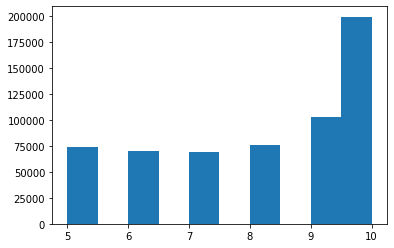

In [4]:
plt.hist([len(item['triple']) for item in a])
plt.show()

In [27]:
sample_to_neo4j(a[5])

MATCH (n) DETACH DELETE (n);
CREATE (:ENT:TARGET {ent:"Ealdred (archbishop of York)"});
CREATE (:ENT:TARGET {ent:"Cathedral chapter"});
CREATE (:ENT:INTERMEDIA {ent:"Archdeacon"});
CREATE (:ENT:INTERMEDIA {ent:"Abbot"});
CREATE (:ENT:INTERMEDIA {ent:"Archbishop of Cologne"});
CREATE (:ENT:INTERMEDIA {ent:"Archbishop of York"});
CREATE (:ENT:INTERMEDIA {ent:"Canon (priest)"});
CREATE (:ENT:INTERMEDIA {ent:"Bishop"});
MATCH (ent1:ENT {ent:"Bishop"}), (ent2:ENT {ent:"Cathedral chapter"}) CREATE (ent1)-[:Sent {sent:"The cathedral chapter of Worms Cathedral elected him as Bishop of Worms on 16 April 1673.", pair:"Bishop <-> Cathedral chapter", score:0.965}]->(ent2);
MATCH (ent1:ENT {ent:"Ealdred (archbishop of York)"}), (ent2:ENT {ent:"Canon (priest)"}) CREATE (ent1)-[:Sent {sent:"In 1066 Ealdred, the Archbishop of York, held the Lordship, this transferring by 1086 to the canons of Beverley, with Thomas of Bayeux, the later Archbishop of York, as Tenant-in-chief to King William I.", pair:"E

In [28]:
random.seed(0)
random.shuffle(a)
train_ratio = 0.96
valid_ratio = 0.02
training_data = a[:int(len(a)*train_ratio)]
valid_data = a[int(len(a)*train_ratio):int(len(a)*(train_ratio+valid_ratio))]
test_data = a[int(len(a)*(train_ratio+valid_ratio)):]
with open('train.json', 'w') as f_out:
    json.dump(training_data, f_out)
with open('dev.json', 'w') as f_out:
    json.dump(valid_data, f_out)
with open('test.json', 'w') as f_out:
    json.dump(test_data, f_out)

In [11]:
a = nx.Graph()
a.add_edge(1,2,a=1)
a.add_edge(2,3,a=7)

In [14]:
a.get_edge_data(1,3) == None

True

### Generate data for level 1 with random path

In [ ]:
entity_occur_from_cooccur = my_read_pickle(entity_occur_from_cooccur_file)

In [ ]:
for file_in, file_out in [('MyFiD/data/train.json', 'train_random.json'), ('MyFiD/data/dev.json', 'dev_random.json'), ('MyFiD/data/test.json', 'test_random.json')]:
    with open(file_in) as f_in:
        data = json.load(f_in)
        for item in tqdm.tqdm(data):
            for path in item['triple']:
                for tri in path:
                    item['source'][tri['sent']] = note2line(random.choice(list(entity_occur_from_cooccur[item['entity'][tri['e1']]] & entity_occur_from_cooccur[item['entity'][tri['e2']]]))).strip()
        with open(file_out, 'w') as f_out:
            json.dump(data, f_out)

In [ ]:
data[0]

In [ ]:
training_data[0]['source']

In [ ]:
training_data[0]['source']

In [ ]:
sent_len_count = []
for data in training_data:
    sents = data['source']
    sent_len_count.extend([len(sent.split()) for sent in sents])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x = np.array(sent_len_count)

In [ ]:
plt.hist(x[x<100])
plt.show()

In [ ]:
len(sent_len_count)

In [ ]:
sample_to_neo4j(items[5])

### Generate data of level 2 from level 1

In [ ]:
with open('temp.json') as f_in:
    sample = json.load(f_in)

In [ ]:
sample

In [ ]:
second_level_sample = generate_second_level_sample(sample)

In [ ]:
second_level_sample

In [ ]:
from graph4nlp.pytorch.data import GraphData

In [ ]:
dep_labels = list(nlp.get_pipe("parser").labels)
dep_labels.extend(['i_'+dep for dep in dep_labels])

In [ ]:
g = GraphData()
is_rel = []
is_entity = []

g.add_nodes(1)
is_rel.append(0)
is_entity.append(0)

for src in second_level_sample['sources']:
    pair = src['pair']
    sent_tokens = src['sent']
    
    label_list = []
    label_list.extend(sent_tokens)
    token_num = len(sent_tokens)
    start_node = g.get_node_num()
    g.add_nodes(token_num)
    is_rel.extend([0]*token_num)
    is_entity.extend([0]*token_num)
    is_entity[pair[0]+start_node] = 1
    is_entity[pair[1]+start_node] = 1
    
    label_list.extend(['ROOT', 'ROOT', 'i_ROOT', 'i_ROOT'])
    rel_start_node = start_node + token_num
    g.add_nodes(4)
    is_rel.extend([1]*4)
    is_entity.extend([0]*4)
    g.add_edges([0, 0], [rel_start_node, rel_start_node+1])
    g.add_edges([rel_start_node, rel_start_node+1], [pair[0]+start_node, pair[1]+start_node])
    g.add_edges([pair[0]+start_node, pair[1]+start_node], [rel_start_node+2, rel_start_node+3])
    g.add_edges([rel_start_node+2, rel_start_node+3], [0, 0])
    
    rel_start_node += 4
    triples = src['graph']
    rel_num = len(triples)
    is_rel.extend([1]*rel_num)
    is_entity.extend([0]*rel_num)
    g.add_nodes(rel_num)
    for rel_idx, (tok_1, tok_2, rel) in enumerate(triples):
        g.add_edges([tok_1+start_node, rel_idx+rel_start_node], [rel_idx+rel_start_node, tok_2+start_node])
        label_list.append(rel)
    for i, label in enumerate(label_list):
        g.node_attributes[i+start_node]['label'] = label
g.node_features['is_rel'] = torch.BoolTensor(is_rel)
g.node_features['is_entity'] = torch.BoolTensor(is_entity)

In [ ]:
g.get_edge_num()

In [ ]:
def find_triangle_with_node(graph:nx.Graph, first_node:str, second_node:str='', third_node:str=''):
    triangles = list(find_triangles(graph, first_node))
    triangles.sort(key=lambda x: x[1])
    triangle_with_sents = []
    n_seen = set()
    for n1, n2, n3 in triangles:
        if second_node and n2 != second_node and n3 != second_node:
            continue
        if third_node and n2 != third_node and n3 != third_node:
            continue
        if n2 not in n_seen:
            n_seen.add(n2)
            triangle_with_sents.append((n1, note2line(graph.get_edge_data(n1, n2)['note']).strip(), n2, graph.get_edge_data(n1, n2)['score']))
        if n3 not in n_seen:
            n_seen.add(n3)
            triangle_with_sents.append((n1, note2line(graph.get_edge_data(n1, n3)['note']).strip(), n3, graph.get_edge_data(n1, n3)['score']))
        triangle_with_sents.append((n2, note2line(graph.get_edge_data(n3, n2)['note']).strip(), n3, graph.get_edge_data(n3, n2)['score']))
    return triangle_with_sents


def isf(w:str, D:int, counters:List[Counter]):
    return math.log(D * 1.0 / sum([1 if w in sent else 0 for sent in counters]))


def do_pagerank(sents:List[str]):
    # Remove stop words
    clean_sents = [[token for token in sent.split() if token not in sw and token not in self_define_stopwords] for sent in sents]

    # Generate word counters
    counters = [Counter(sent) for sent in clean_sents]

    # Build similarity matrix
    D = len(clean_sents)
    sim_matrix = np.zeros((D, D))
    part_list = [math.sqrt(sum([(sent[w] * isf(w, D, counters)) ** 2 for w in sent])) for sent in counters]
    # return part_list
    for i in range(D - 1):
        for j in range(i + 1, D):
            sent_1 = counters[i]
            sent_2 = counters[j]
            share_word_set = sent_1 & sent_2
            numerator = sum([(sent_1[w] * sent_2[w] * (isf(w, D, counters) ** 2)) for w in share_word_set])
            denominator = part_list[i] * part_list[j]
            sim_matrix[i, j] = numerator / denominator
    sim_matrix = sim_matrix + sim_matrix.T
    g = nx.from_numpy_array(sim_matrix)
    score = nx.pagerank(g)
    temp = sorted(score.items(), key=lambda x: x[1], reverse=True)
    idx = [item[0] for item in temp]
    return [sents[i] for i in idx], [score[i] for i in idx]

In [ ]:
test_triangles = find_triangle_with_node(single_sent_graph, 'Machine learning', 'Artificial neural network', 'Deep learning')
test_triangles

In [ ]:
sent_list = [triangle[1] for triangle in test_triangles]
sents, score = do_pagerank(sent_list)
list(zip(score, sents))

## Generate Super Sub-graph

### Collect all sentences between two entities within one hop

In [ ]:
# [Load] Single sentence graph
single_sent_graph = my_read_pickle(single_sent_graph_file)
edges = [edge for edge in tqdm.tqdm(single_sent_graph.edges) if single_sent_graph.get_edge_data(*edge)['score'] > 0.65]
filtered_graph = single_sent_graph.edge_subgraph(edges)
print('number of nodes:', filtered_graph.number_of_nodes())
print('number of edges:', filtered_graph.number_of_edges())

In [ ]:
paths = find_path_between_pair(single_sent_graph, 'Artificial intelligence', 'Natural language processing', 1)

In [ ]:
def build_subgraph(paths:list, single_sent_graph:nx.Graph):
    pairs = set()
    triples = []
    for path in paths:
        if len(path) <= 2:
            continue
        for i in range(len(path)-1):
            new_pair = frozenset((path[i], path[i+1]))
            if new_pair not in pairs:
                pairs.add(new_pair)
                triples.append(list(new_pair) + [note2line(single_sent_graph.get_edge_data(path[i], path[i+1])['note']).strip()])
    return triples

In [ ]:
subgraph = build_subgraph(paths, single_sent_graph)

### Generate a graph for one sentence

## Demo

In [ ]:
# Analyze sentence
doc = nlp('sephardi were exempt from the ban , but it appears that few applied for a letter of free passage .')

# Check noun phrases in the sentences
print(list(doc.noun_chunks))

In [ ]:
len(doc)

In [ ]:
doc = nlp('ada is a structured , statically typed , imperative , and object-oriented high-level programming language , extended from pascal and other language .')
pairs = [{'kw1' : 'ada', 'kw2' : 'programming language'}]
feature_process(doc, pairs)

## [Not necessary] Online operations

In [ ]:
def collect_sents_from_wiki_page(page:wikipedia.WikipediaPage):
    remove_list = ['See also', 'References', 'Further reading', 'Sources', 'External links']
    dic = {sec : page.section(sec) for sec in page.sections}
    dic['summary'] = page.summary
    sents = []
    section_list = list(dic.keys())
    while len(section_list) > 0:
        section = section_list.pop()
        if section in remove_list:
            continue
        section_text = dic[section]
        if not section_text:
            continue
        # processed_text = clean_text(section_text)
        processed_text = ' '.join(section_text.lower().split())
        temp_sents = my_sentence_tokenize(processed_text, True)
        sents += temp_sents
    return list(sents)

def collect_entity_from_wiki_page(page:wikipedia.WikipediaPage):
    return [text.lower() for text in page.links]

def collect_keyword_from_wiki_page(page:wikipedia.WikipediaPage):
    soup = BeautifulSoup(page.html(), 'html.parser')
    main_block = soup.find('div', class_='mw-parser-output')
    keywords = set([l.text.lower() for l in main_block.findAll('a') if re.match(r'^(<a href="/wiki/)', str(l))])
    return keywords



In [ ]:
keyword = 'python'

p = wikipedia.page(keyword)
if p is not None:
    sents = collect_sents_from_wiki_page(p)
    keywords = collect_keyword_from_wiki_page(p)
    print('sentences collected')
    my_write('%s.txt' % keyword, sents)
    my_write('%s_kw.txt' % keyword, keywords)
    df = filter_by_path(sents)
    df.to_csv('%s_out.tsv' % keyword, sep='\t', index=False)

    dff = df[df.apply(lambda x: str(x['head']) in keywords and str(x['tail']) in keywords, axis=1)]
    dff.to_csv('%s_out_f.tsv' % keyword, sep='\t', index=False)

# Appendix

## Hand-crafted analysis

In [ ]:
wiki_test_df = wiki_path_test_df[wiki_path_test_df['sim'] >= 0.0]

def match_path_pattern(path:str):
    for pp in patterns:
        if exact_match(pp, path):
            return pp
    return ''

wiki_test_df['pattern'] = wiki_test_df.apply(lambda x: match_path_pattern(x['path']), axis=1)

In [ ]:
def analysis_path_result_sim_based(df:pd.DataFrame, paths:list):
    summary_df = pd.DataFrame(columns=['path', 'cnt', 'ratio', 'avg_sim'])
    for pp in paths:
        sub_df = df[df['pattern'] == pp]
        summary_df = summary_df.append({
            'path' : pp,
            'cnt' : len(sub_df),
            'ratio' : len(sub_df) / len(df),
            'avg_sim' : sum(sub_df['sim']) / len(sub_df) if len(sub_df) else 0
        }, ignore_index=True)
    summary_df = summary_df.append({
        'path' : 'general',
        'cnt' : len(df),
        'ratio' : 1,
        'avg_sim' : sum(df['sim']) / len(df) if len(df) else 0
    }, ignore_index=True)
    return summary_df

In [ ]:
analysis_path_result_sim_based(wiki_test_df, patterns)

In [ ]:
def collect_example_sent_for_pattern(df:pd.DataFrame, path:str, num:int=30, posfix:str='.dat'):
    sub_df = df[df['pattern'] == path]
    num = min(len(sub_df), num)
    sub_df = sub_df[:num]
    sub_df['sent'] = sub_df.apply(lambda x: note2line(x['sent'], posfix=posfix).strip(), axis=1)
    return sub_df

for patt in patterns:
    temp_df = collect_example_sent_for_pattern(wiki_test_df, patt)
    temp_df.to_csv('%s.tsv' % (patt[:10] if len(patt) >= 10 else patt), index=False, sep='\t')

In [ ]:
triangle_set = my_read_pickle('data/extract_wiki/triangles.pickle')

In [ ]:
len(triangle_set)

In [ ]:
for i, tri in enumerate(triangle_set):
    print(tri)
    if i > 10:
        break

In [ ]:
samples = []
for i, tri in enumerate(triangle_set):
    samples.append(find_triangle_with_node(single_sent_graph, *tri))
    if i > 10:
        break


In [ ]:
samples